# Шаг 2: BaseLine EDA
> Проведение быстрого анализа данных для построения BaseLIne

## Импорт библиотек

In [61]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 50)
pd.options.display.max_rows = 20

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook


import association_metrics as am
from sklearn.decomposition import PCA

In [62]:
RANDOM_STATE = 42

## Загрузка данных

In [63]:
initial_X_y = pd.read_pickle('../data/initial_X_y.pkl')
X = initial_X_y['X'].copy()
y = initial_X_y['y'].copy()

In [64]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [65]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

## Разведочный анализ данных

Выделим категориальные и числовые признаки

In [66]:
numeric_cols = list(X.select_dtypes(include=[np.number]).columns)
display(X[numeric_cols].head(3))

,tenure,MonthlyCharges,TotalCharges
0,1.0,29.85,29.85
1,34.0,56.95,1889.50
2,2.0,53.85,108.15


In [67]:
categoric_cols = list(X.select_dtypes(exclude=[np.number]).columns)
display(X[categoric_cols].head(3))

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check


### Числовые признаки

Посмотрим на распределения числовых признаков

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.54it/s]


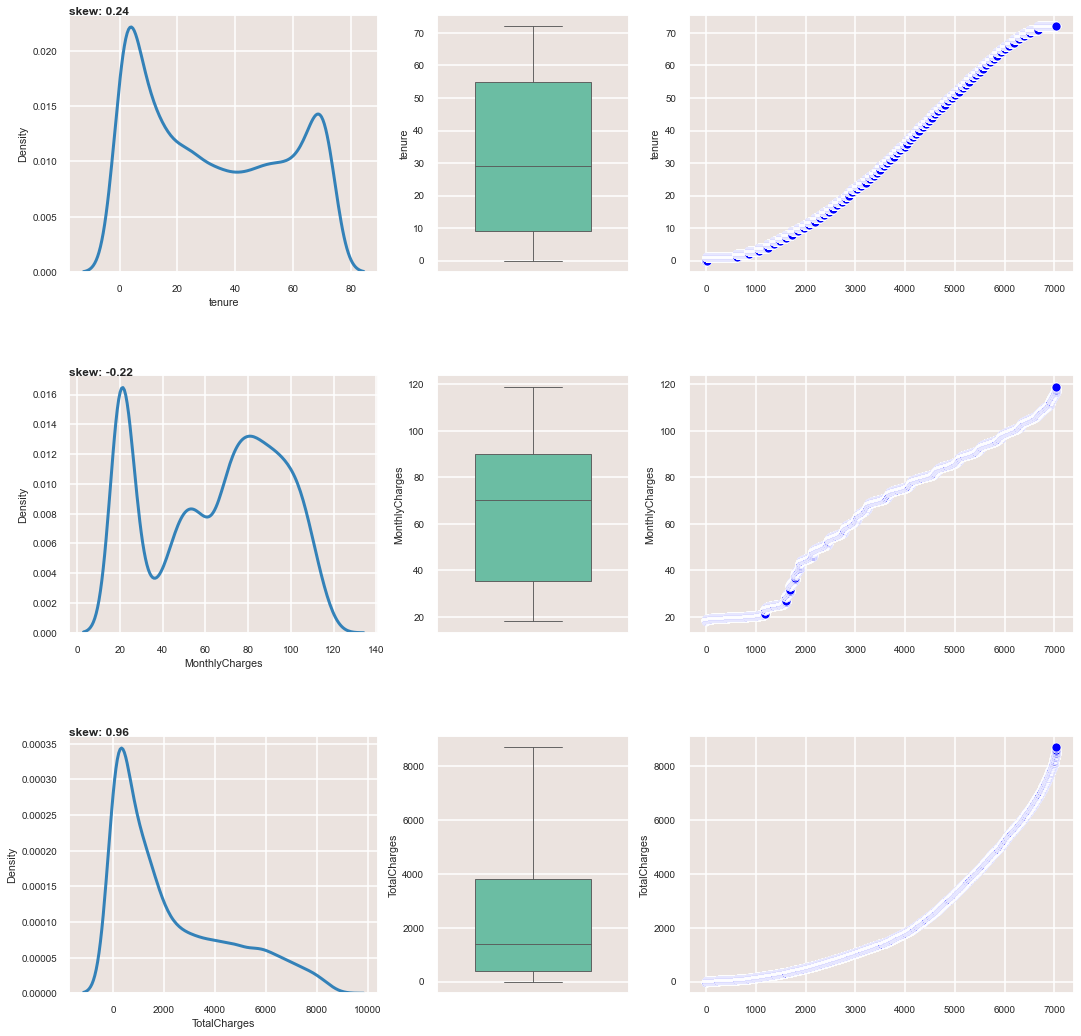

In [68]:
import math
from tqdm import tqdm
def plot_numUFA(df: pd.DataFrame, num_columns: list=None):
    
    assert num_columns!=None, 'Не передан список числовых признаков'

    skewness_list = df[num_columns].skew()
    
    subplot_cnt = len(num_columns)*3
    
    
    n_col = 3
    if len(num_columns) <= n_col/3:
        n_col = 3
        n_row = 1
    else:
        n_row = math.ceil(subplot_cnt / n_col)
    

    fig, axes = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(n_col * 6, n_row * 6),
        gridspec_kw={"hspace": 0.4, "wspace": 0.2, "width_ratios": [0.8, 0.5, 1]},
    )
    axes = axes.flatten()
    i = 0
    for column in tqdm(num_columns):

         # __Распределение__
        ax = axes[i]
        sns.kdeplot(data=df, 
                    x=column, 
                    ax=ax, 
                    fill=False, 
                    alpha=0.9, 
                    legend=False, 
                    linewidth=3, 
                    palette = 'Set2',
                   )

        skewness = skewness_list[column]
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[-1],
            f"skew: {skewness:.2f}",
            size=12,
            weight="bold",
        )
        i = i+1



        #__Бокс__
        ax = axes[i]
        sns.boxplot(
            data=df,
            #x="Churn",
            y=column,
            ax=ax,
            width=0.6,
            saturation=0.9,
            linewidth=0.9,
            palette='Set2',
        )

        i =i + 1



        # __Монотонность__
        df_local = df.copy()
        df_local = df_local.sort_values(by=column).reset_index(drop=True)
        ax = axes[i]
        sns.scatterplot(
            data=df_local, x=df_local.index, y=column,alpha=1, ax=ax, color='b', palette='Set2'
        )
        i = i+1
        
plot_numUFA(X[numeric_cols], num_columns=numeric_cols)

Можем отметить:
- У признаков `tenure` и `MonthlyCharges` наблюдается биномиальное распределение с двумя центрами сосредоточения.
- У признака `TotalCharges` наблюдается сильный скос влево.
- У всех признаков не наблюдается наличие значительных выбросов.

Посмотрим на наличие линейной корреляции между числовыми признаками

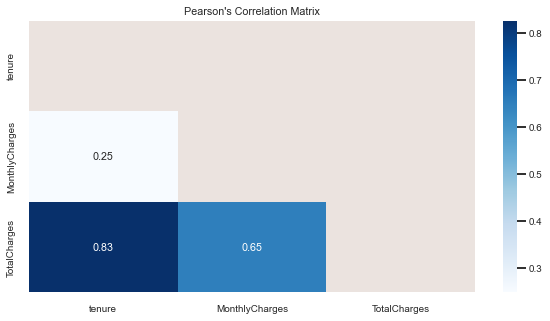

In [69]:
# Проверка ортогональности

corr = X[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(corr, mask=mask, annot=True, cmap="Blues", fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

- Наблюдается сильная корреляция между признаками `tenure` и `TotalCharges`, что полностью объяснимо значениями признаков.
- Наблюдается признаки наличия корреляции между `TotalCharges` и `MonthlyCharges`. 

### Категориальные признаки

#### Посмотрим на категориальные признаки

In [70]:
def get_catFA(dataframe: pd.DataFrame, short=True):
    cat_cols = dataframe.select_dtypes(exclude="number")
    uni_values = []
    counts = []
    pct = []
    balance_rate = []

    for col in cat_cols.columns:
        uni_value, count = np.unique(
            np.array(cat_cols[col], dtype=str), return_counts=True
        )
        uni_values.append(uni_value)
        counts.append(count)
        pct.append(np.round(count / count.sum() * 100, 2))
        balance_rate.append(100 - min(np.round(count / count.sum() * 100, 2))*len(count))
    
    if short is False:
        result = pd.DataFrame(
            {
                "dtype": cat_cols.dtypes,
                "unique_values": uni_values,
                "counts": [len(val) for val in uni_values],
                "values_count": counts,
                "%": pct,
                'imbalance_rate': balance_rate
            } )
        result = result.sort_values(by='imbalance_rate', ascending=False)
        cm = sns.light_palette('orange', as_cmap=True)
        result = result.style.background_gradient( cmap=cm, axis=0, subset=['imbalance_rate'], vmin=20)
    
    if short is True:
         result = pd.DataFrame(
            {
                "dtype": cat_cols.dtypes,
                "unique_values": uni_values,
                "counts": [len(val) for val in uni_values],
                "%": pct,
                'imbalance_rate': balance_rate
            } )
    
    return result

In [71]:
result = get_catFA(X[categoric_cols], short=True)
display(result)

,dtype,unique_values,counts,%,imbalance_rate
gender,object,"[Female, Male]",2,"[49.52, 50.48]",0.96
SeniorCitizen,object,"[No, Yes]",2,"[83.79, 16.21]",67.58
Partner,object,"[No, Yes]",2,"[51.7, 48.3]",3.40
Dependents,object,"[No, Yes]",2,"[70.04, 29.96]",40.08
PhoneService,object,"[No, Yes]",2,"[9.68, 90.32]",80.64
MultipleLines,object,"[No, No phone service, Yes]",3,"[48.13, 9.68, 42.18]",70.96
InternetService,object,"[DSL, Fiber optic, No]",3,"[34.37, 43.96, 21.67]",34.99
OnlineSecurity,object,"[No, No internet service, Yes]",3,"[49.67, 21.67, 28.67]",34.99
OnlineBackup,object,"[No, No internet service, Yes]",3,"[43.84, 21.67, 34.49]",34.99
DeviceProtection,object,"[No, No internet service, Yes]",3,"[43.94, 21.67, 34.39]",34.99


- У признаков `SeniorCitizen`, `PhoneService`, `MultipleLines` наблюдается сильный дисбаланс категорий.

#### Посмотрим на аналог корреляции категориальных признаков

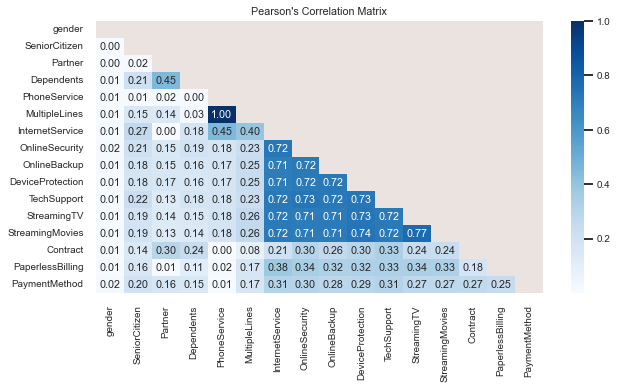

In [73]:
X_temp = X[categoric_cols].astype('category')
cramersv = am.CramersV(X_temp)
cramersv.fit()

mask = np.triu(np.ones_like(cramersv.matrix, dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(cramersv.matrix, mask=mask, annot=True, cmap="Blues", fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

- Значение статистики для пары признаков `MultipleLines`, `PhoneService` равно **1**, что говорит о максимальной корреляции.
- Наблюдается значительная корреляция признаками `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`.

#### Посмотрим на пару признаков `MultipleLines`, `PhoneService` поближе:

In [17]:
display(X['MultipleLines'].value_counts())
display(X['PhoneService'].value_counts())

No                  3368
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Yes    6339
No      682
Name: PhoneService, dtype: int64

Возможно признак `MultipleLines` включает в себя признак `PhoneService`. Проверим это:

In [18]:
X[['MultipleLines', 'PhoneService']].apply(lambda x: str(x['MultipleLines']) + str(x['PhoneService']), axis=1).value_counts()

NoYes                 3368
YesYes                2971
No phone serviceNo     682
dtype: int64

- Очевидно, что признак `PhoneService` не носит информационной ценности

### Целевой признак

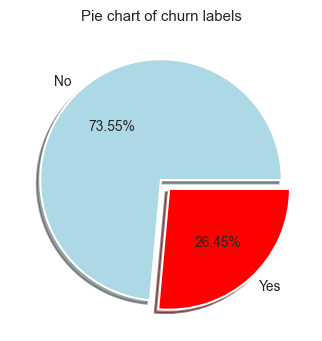

In [22]:
churn_label_count = y.value_counts()
fig = plt.figure(figsize=(7, 4), dpi=100)
plt.pie(
    churn_label_count,
    autopct="%.2f%%",
    labels=churn_label_count.index,
    colors=["lightblue", "red"],
    explode=[0, 0.1],
    shadow=True,
)
plt.title("Pie chart of churn labels")
plt.show()

- Наблюдается значительный дисбаланс классов.

#### Посмотрим на корреляцию целевого признака с другими категориальными

In [23]:
X_temp = pd.concat([X[categoric_cols], y], axis=1).astype('category')
cramersv = am.CramersV(X_temp)
cramersv.fit()

cramersv.matrix['Churn'].sort_values(ascending=False)

Churn               1.000000
Contract            0.409926
OnlineSecurity      0.347285
TechSupport         0.342789
InternetService     0.322904
PaymentMethod       0.302843
OnlineBackup        0.292081
DeviceProtection    0.281380
StreamingMovies     0.231294
StreamingTV         0.230870
PaperlessBilling    0.190891
Dependents          0.163459
SeniorCitizen       0.151619
Partner             0.149135
MultipleLines       0.041961
PhoneService        0.011323
gender              0.008763
Name: Churn, dtype: float64

- Не наблюдается наличие сильной корреляции между категориальными признаками и целевым

#### Посмотрим на наличие корреляции целевого признака с числовыми

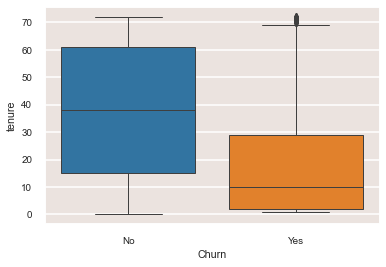

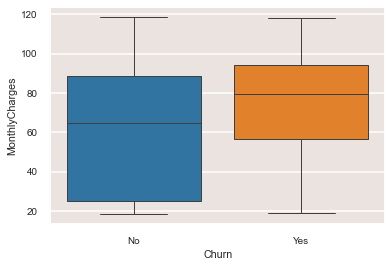

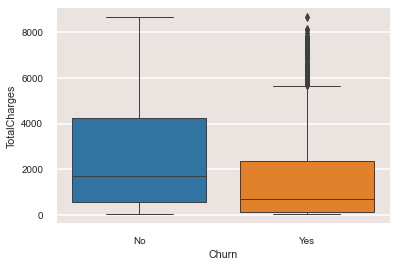

In [24]:
for col in numeric_cols:
    sns.boxplot(y, X[col], orient='v')
    plt.show()

- Наблюдается заметное расхождение средних значений признака `tenure` по категориям целевого признака. Это может говорить о потенциально сильной предсказательной способности.